In [ ]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,cross_val_predict, GridSearchCV,train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from datetime import datetime
seed= 1000
np.random.seed(seed)
import math
from google.colab import drive
drive.mount('/content/drive')
#_______________________________________________________________________________
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#_______________________________________________________________________________

Mounted at /content/drive


In [ ]:
# functions definition
def plot_results(preds,true,target,r2,mse):
  fig, axs = plt.subplots(1,2, figsize=(12, 4), facecolor='w', edgecolor='k')
  axs = axs.ravel()
  j=0

  for i in range(2):
    start=min(true[j].min(),preds[j].min())
    end=max(true[j].max(),preds[j].max())
    axs[i].scatter(preds[j],true[j],facecolors='none',edgecolors='r',s=80)
    axs[i].plot([start,end],[start,end],'k--')
    axs[i].set_xlabel('predicted')
    axs[i].set_ylabel('truth')
    axs[i].set_title(f"{target[j]}: R2={round(r2[j]*100,1)}%, MSE={round(mse[j],3)}")
    j=j+1
#______________________________________________________________________________________________________
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
# read file
df = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Geomechanical_Properties_Prediction_DataSet.xlsx')

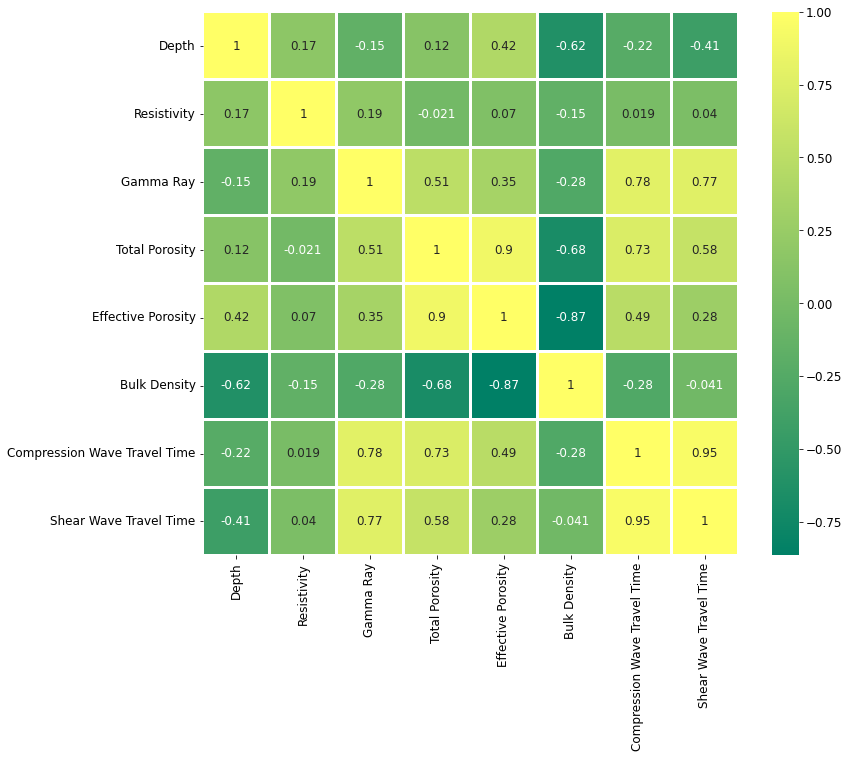

In [ ]:
# plot correlations
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, linecolor='white',linewidths=2, cmap= 'summer')

In [ ]:
# perform scaling
scaler=MinMaxScaler(feature_range=(0,1))
scaler.fit(df)
df_scaled=scaler.transform(df)

In [ ]:
# convert scaled array back to dataframe
cols=['Depth', 'Resistivity', 'Gamma Ray','Total Porosity','Effective Porosity', 
      'Bulk Density','Compression Wave Travel Time', 'Shear Wave Travel Time']
df_scaled=pd.DataFrame(df_scaled, columns=cols)
# specify targets
y_scaled=df_scaled[['Compression Wave Travel Time', 'Shear Wave Travel Time']]
# set features
x_scaled=df_scaled.drop(['Compression Wave Travel Time', 'Shear Wave Travel Time'], axis=1)
# train-test split
X_train,X_test,y_train, y_test= train_test_split(x_scaled, y_scaled, test_size=0.30)

# **Baseline Model**

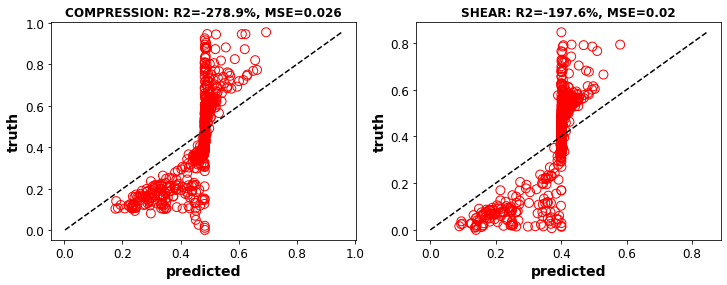

In [ ]:
# define baseline model
# this is the model given in the
# problem statement
baseline = MultiOutputRegressor((SVR(kernel='rbf', gamma=1000, C=1000)))
# model fit
baseline.fit(X_train,y_train)
# model predict
predictions_test=baseline.predict(X_test)
# evaluate prediction metrics
# for compression and shear
mse_compression=metrics.mean_squared_error(predictions_test[:,0],y_test['Compression Wave Travel Time'])
r2_compression=metrics.r2_score(predictions_test[:,0],y_test['Compression Wave Travel Time'])
mse_shear=metrics.mean_squared_error(predictions_test[:,1],y_test['Shear Wave Travel Time'])
r2_shear=metrics.r2_score(predictions_test[:,1],y_test['Shear Wave Travel Time'])
# plot results
preds=[predictions_test[:,0],predictions_test[:,1]]
true=[y_test['Compression Wave Travel Time'],y_test['Shear Wave Travel Time']]
target=["COMPRESSION","SHEAR"]
r2=[r2_compression,r2_shear]
mse=[mse_compression,mse_shear]
plot_results(preds,true,target,r2,mse)

**Parte A:** Treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, gamma) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, gamma) afetaram a qualidade do seus regressores. A busca pelos hiperparâmetros deve usar um método formal como GridSearch, RandomSearch, etc.

Utilize o conjunto transformado pelas células acima `(X_train, y_train)` e `(X_test, y_test)`. 

In [ ]:
#_______________________________________________________________________________ 
# SVR HYPERPARAMETERS CHEAT SHEET
# gamma: scale parameter 
#    * low gamma-->large receptive field,
#    * large gamma-->short receptive field
# C: regularization parameter
#    * low C-->strong regularization
#    *large C-->weak regularization
#_______________________________________________________________________________ 

* We apply **Nested K-Fold Cross Validation**, where the inner loop searches for the best hyperparameters using GridSearchCV (with 3-folds), and the outer loop yields an estimate for the **generalization error**.

* The outer loop contains 5-folds and we report the MSE for each fold, as well as the average MSE. The average MSE can be deemed as the generalization error estimate.

* We test 3 SVR grids. Each candidate grid has a different kernel and different grids for C and gamma.


In [ ]:
# define 3 hyper-param grids
grid1 = {'estimator__kernel':['linear'],
         'estimator__C':[0.1,1,10,100],
         'estimator__gamma':[10,0.1,0.01]}
grid2 = {'estimator__kernel':['rbf'],
         'estimator__C':[0.1,1,10,100,1000],
         'estimator__gamma':[10,1,0.1,0.01,1000]}
grid3 = {'estimator__kernel':['sigmoid'],
         'estimator__C':[0.1,1,10,100,1000],
         'estimator__gamma':[1,0.1,0.01,1000]}
# define list of grids
# each grid will lead to a different SVR model
grid_list=[grid1,grid2,grid3]
# inner 3-fold loop for hyper-params selection
cv_inner =  KFold(n_splits=3, shuffle=True, random_state=seed)
# invoke SVR
model= SVR()
# define wrapper for multi-output regressor
wrapper = MultiOutputRegressor(model)
# outer loop for generalization error 
# enumerate 5 splits
kfold = KFold(5, shuffle=True,random_state= seed)
for grid in grid_list:
  # define grid search CV for 
  # hyper params selection
  gs= GridSearchCV(estimator=wrapper,
                  param_grid = grid,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
  # create lists for evaluation metrics  
  mse_comp=[]
  mse_sh=[]
  # initiate k-fold cross validation outer loop
  # obtain "train" indexes and "val" indexes for
  # each fold
  for train, val in kfold.split(X_train.values):
    # find best set of hyper params for current train fold
    grid_result=gs.fit(X_train.iloc[train],y_train.iloc[train])
    # extract best_params for current train fold
    best_params = grid_result.best_params_
    # define best model for current train fold 
    best_model = MultiOutputRegressor((SVR(kernel=best_params['estimator__kernel'],
                                        gamma=best_params['estimator__gamma'],
                                        C=best_params['estimator__C'])))
    # fit best model on current train fold
    best_model.fit(X_train.iloc[train],y_train.iloc[train])
    # make predictions on current validation set
    # of current fold
    predictions=best_model.predict(X_train.iloc[val])
    # compute MSE for compression
    mse_compression=metrics.mean_squared_error(predictions[:,0],y_train['Compression Wave Travel Time'].iloc[val])
    mse_comp.append(mse_compression)
    # compute MSE for shear
    mse_shear=metrics.mean_squared_error(predictions[:,1],y_train['Shear Wave Travel Time'].iloc[val])
    mse_sh.append(mse_shear)
  # print results  
  print(f"Kernel type: {list(grid.values())[0]}")
  print(f"Compression Wave--> MSE on 5-fold:{np.round(mse_comp,3)}")
  print(f"Compression Wave--> AVG MSE on 5-fold:{np.round(np.mean(mse_comp),3)}")
  print(f"Compression Wave--> STD MSE on 5-fold:{np.round(np.std(mse_comp),3)}")
  print(f"Shear Wave--> MSE on 5-fold:{np.round(mse_sh,3)}")
  print(f"Shear Wave--> AVG MSE on 5-fold:{np.round(np.mean(mse_sh),3)}")
  print(f"Shear Wave--> STD MSE on 5-fold:{np.round(np.std(mse_sh),3)}")
  print("==================================================================")

Kernel type: ['linear']
Compression Wave--> MSE on 5-fold:[0.008 0.011 0.007 0.008 0.006]
Compression Wave--> AVG MSE on 5-fold:0.008
Compression Wave--> STD MSE on 5-fold:0.001
Shear Wave--> MSE on 5-fold:[0.007 0.008 0.006 0.007 0.006]
Shear Wave--> AVG MSE on 5-fold:0.007
Shear Wave--> STD MSE on 5-fold:0.001
Kernel type: ['rbf']
Compression Wave--> MSE on 5-fold:[0.003 0.004 0.004 0.003 0.005]
Compression Wave--> AVG MSE on 5-fold:0.004
Compression Wave--> STD MSE on 5-fold:0.001
Shear Wave--> MSE on 5-fold:[0.003 0.003 0.003 0.003 0.003]
Shear Wave--> AVG MSE on 5-fold:0.003
Shear Wave--> STD MSE on 5-fold:0.0
Kernel type: ['sigmoid']
Compression Wave--> MSE on 5-fold:[0.008 0.011 0.007 0.008 0.007]
Compression Wave--> AVG MSE on 5-fold:0.008
Compression Wave--> STD MSE on 5-fold:0.001
Shear Wave--> MSE on 5-fold:[0.007 0.008 0.006 0.007 0.006]
Shear Wave--> AVG MSE on 5-fold:0.007
Shear Wave--> STD MSE on 5-fold:0.001


The Nested-Cross Validation procedure reveals that:
  * The lowest generalization error for Compression Wave: **MSE=0.004** with a **STD=0.001**.
  * The lowest generalization error for Shear Wave: **MSE=0.003** and **STD=0.0**.
  * Linear Kernel Compression Wave MSEs (5 validation folds):**[0.008 0.011 0.007 0.008 0.006]**
  * Linear Kernel Shear Wave MSEs (5 validation folds):**[0.007 0.008 0.006 0.007 0.006]**
  * RBF Kernel Compression Wave MSEs (5 validation folds): **[0.003 0.004 0.004 0.003 0.005]**
  * RBF Kernel Shear Wave MSEs (5 validation folds): **[0.003 0.003 0.003 0.003 0.003]**
  * Sigmoid Kernel Compression Wave MSEs (5 validation folds): **[0.008 0.011 0.007 0.008 0.007]**
  * Sigmoid Kernel Shear Wave MSEs (5 validation folds): **[0.007 0.008 0.006 0.007 0.006]**
  * **The lowest generalization errors were obtained from the RBF kernel.**
  * The generalization error for RBF Kernels with the C and gamma grids used in this example are 0.004 for Compression and 0.003 for Shear.



---



* We would like to compare the results of grid-searching the training set for the best parameters with the results from the baseline model on the TEST SET.

* As a refresher, the baseline model yields on the test set **MSE=0.026** and **MSE=0.02** for Compression and Shear, respectively.

* We also would like to check whether our generalization error estimate obtained previously holds true.

Best parameters:{'estimator__C': 1, 'estimator__gamma': 10, 'estimator__kernel': 'rbf'}

 Time taken: 0 hours 0 minutes and 8.36 seconds.


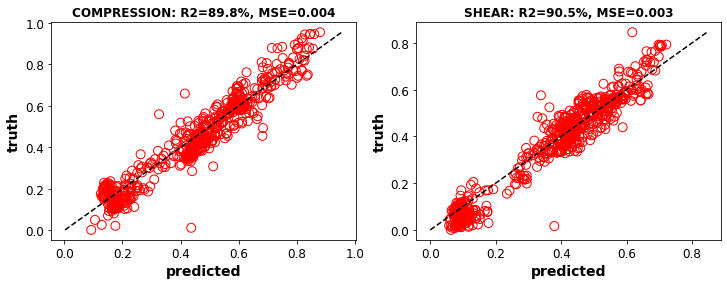

In [ ]:
# chronometer on
start_time = timer(None)
# define grid
my_grid = {'estimator__kernel':['linear','rbf','sigmoid'],
         'estimator__C':[0.1,1,10,100],
         'estimator__gamma':[10,0.1,0.01]}
# invoke SVR
model= SVR()
# define wrapper for multi-output regressor
wrapper = MultiOutputRegressor(model)
# define grid search
gs= GridSearchCV(estimator=wrapper,
                  param_grid = my_grid,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
# perform GridSearch on the entire
# training set in order to find
# best params
grid_result = gs.fit(X_train, y_train)
# extract  best_parms
best_params = grid_result.best_params_
# define best SVR model
best_model_svr=MultiOutputRegressor(SVR(C=best_params['estimator__C'],
            gamma=best_params['estimator__gamma'],
            kernel=best_params['estimator__kernel']))
# fit best SVR model
best_model_svr.fit(X_train,y_train)
# make predictions on test set
predictions=best_model_svr.predict(X_test)
# evaluate prediction metrics
# for compression and shear
mse_compression=metrics.mean_squared_error(predictions[:,0],y_test['Compression Wave Travel Time'])
r2_compression=metrics.r2_score(predictions[:,0],y_test['Compression Wave Travel Time'])
mse_shear=metrics.mean_squared_error(predictions[:,1],y_test['Shear Wave Travel Time'])
r2_shear=metrics.r2_score(predictions[:,1],y_test['Shear Wave Travel Time'])
# plot results
preds=[predictions[:,0],predictions[:,1]]
true=[y_test['Compression Wave Travel Time'],y_test['Shear Wave Travel Time']]
target=["COMPRESSION","SHEAR"]
r2=[r2_compression,r2_shear]
mse=[mse_compression,mse_shear]
print(f"Best parameters:{grid_result.best_params_}")
plot_results(preds,true,target,r2,mse)
# save results to df
results_list=[]
results_list.append([["SVR"],mse[0],mse[1]])
results_df=pd.DataFrame(results_list)
results_df.columns=["model","MSE COMP","MSE SHEAR"]
# chronometer off
timer(start_time)

* The best SVR model has a RBF kernel with C=1 and gamma=10. When compared with the baseline model, also featuring a RBF kernel, with, however, higher C and gamma (C_baseline=1000, gamma_baseline=1000), we realize the baseline model hyperparameters were polar opposites with the "optimal" hyperparameters.
* The baseline model has a very weak regularization term and a Gaussian kernel with a very short-sighted receptive field. The perfect recipe for overfitting the training set and delivering poor generalization, as evidenced by the resulting MSEs.
* The GridSearchCV yields a model with stronger regularization, so as to make the resulting hypothesis less wiggly, and therefore less prone to overfitting. In addition, its RBF kernel features a Gaussian with a much slower decay-rate than the baseline´s. As a result, the resulting kernel receptive field is wider as opposed to being too short-sighted like the baseline model. Kernels with a narrow receptive field are more likely to overfit the training set.
* Therefore, in order to tweak the baseline model hyper-parameters so as to yield lower MSEs, the GridSearchCV would have to simultaneously search for lower Cs and lower gammas. That way, the resulting model would be less likely to overfit the training set.
* As for the generalization error obtained from the Nested-CV, the results on the TEST SET were in line with the previous estimates, namely MSE=0.004 for Compression and MSE=0.003 for Shear. 

**Parte B:** Treine 2 outros regressores (árvore de regressão e random forest) e compare o resultado dos modelos com a sua melhor SVR no conjunto de teste, discutindo os resultados.

Utilize o conjunto transformado pelas células acima `(X_train, y_train)` e `(X_test, y_test)`. 

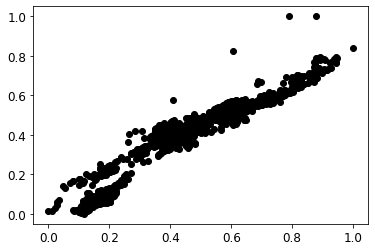

In [ ]:
plt.plot(np.array(y_train)[:,0],np.array(y_train)[:,1],'ko')

**Decision Trees**

In [ ]:
# Using Nested-CV for estimating the generalization error
# define hyper-param grids
grid1 = {'estimator__max_depth':[5,15,25,30],
         'estimator__min_samples_split':[1,2,5,10,15],
         'estimator__min_samples_leaf':[1,2,5,10],
         'estimator__max_features':["log2","sqrt",None]}
# define list of grids
# each grid will lead to a different DT model
grid_list=[grid1]
# inner 3-fold loop for hyper-params selection
cv_inner =  KFold(n_splits=3, shuffle=True, random_state=seed)
# invoke DT
model= DecisionTreeRegressor()
# define wrapper for multi-output regressor
wrapper = MultiOutputRegressor(model)
# outer loop for generalization error 
# enumerate 5 splits
kfold = KFold(5, shuffle=True,random_state= seed)
for grid in grid_list:
  # define grid search CV for 
  # hyper params selection
  gs= GridSearchCV(estimator=wrapper,
                  param_grid = grid,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
  # create lists for evaluation metrics  
  mse_comp=[]
  mse_sh=[]
  # initiate k-fold cross validation outer loop
  # obtain "train" indexes and "val" indexes for
  # each fold
  for train, val in kfold.split(X_train.values):
    # find best set of hyper params for current train fold
    grid_result=gs.fit(X_train.iloc[train],y_train.iloc[train])
    # extract best_params for current train fold
    best_params = grid_result.best_params_
    # define best model for current train fold 
    best_model = MultiOutputRegressor((DecisionTreeRegressor(max_depth=best_params['estimator__max_depth'],
                                        min_samples_split=best_params['estimator__min_samples_split'],
                                        min_samples_leaf=best_params['estimator__min_samples_leaf'],
                                        max_features=best_params['estimator__max_features'])))
    # fit best model on current train fold
    best_model.fit(X_train.iloc[train],y_train.iloc[train])
    # make predictions on current validation set
    # of current fold
    predictions=best_model.predict(X_train.iloc[val])
    # compute MSE for compression
    mse_compression=metrics.mean_squared_error(predictions[:,0],y_train['Compression Wave Travel Time'].iloc[val])
    mse_comp.append(mse_compression)
    # compute MSE for shear
    mse_shear=metrics.mean_squared_error(predictions[:,1],y_train['Shear Wave Travel Time'].iloc[val])
    mse_sh.append(mse_shear)
  # print results  
  print(f"Compression Wave--> MSE on 5-fold:{np.round(mse_comp,3)}")
  print(f"Compression Wave--> AVG MSE on 5-fold:{np.round(np.mean(mse_comp),3)}")
  print(f"Compression Wave--> STD MSE on 5-fold:{np.round(np.std(mse_comp),3)}")
  print(f"Shear Wave--> MSE on 5-fold:{np.round(mse_sh,3)}")
  print(f"Shear Wave--> AVG MSE on 5-fold:{np.round(np.mean(mse_sh),3)}")
  print(f"Shear Wave--> STD MSE on 5-fold:{np.round(np.std(mse_sh),3)}")
  print("==================================================================")

Compression Wave--> MSE on 5-fold:[0.001 0.002 0.004 0.003 0.002]
Compression Wave--> AVG MSE on 5-fold:0.003
Compression Wave--> STD MSE on 5-fold:0.001
Shear Wave--> MSE on 5-fold:[0.001 0.002 0.002 0.002 0.003]
Shear Wave--> AVG MSE on 5-fold:0.002
Shear Wave--> STD MSE on 5-fold:0.0


Best parameters:{'estimator__max_depth': 15, 'estimator__max_features': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 15}

 Time taken: 0 hours 0 minutes and 5.43 seconds.


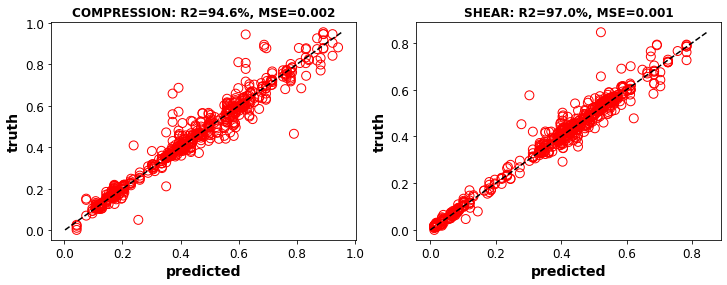

In [ ]:
# timer on
start_time = timer(None)
# define grid
my_grid = {'estimator__max_depth':[5,15,25,30],
         'estimator__min_samples_split':[1,2,5,10,15],
         'estimator__min_samples_leaf':[1,2,5,10],
         'estimator__max_features':["log2","sqrt",None]}
# invoke DT
model= DecisionTreeRegressor()
# define wrapper for multi-output regressor
wrapper = MultiOutputRegressor(model)
# define grid search
gs= GridSearchCV(estimator=wrapper,
                  param_grid = my_grid,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
# perform GridSearch on the entire
# training set in order to find
# best params
grid_result = gs.fit(X_train, y_train)
# extract  best_parms
best_params = grid_result.best_params_
# define best DT model
best_model_dt = MultiOutputRegressor((DecisionTreeRegressor(max_depth=best_params['estimator__max_depth'],
                                        min_samples_split=best_params['estimator__min_samples_split'],
                                        min_samples_leaf=best_params['estimator__min_samples_leaf'],
                                        max_features=best_params['estimator__max_features'])))
# fit best DT model
best_model_dt.fit(X_train,y_train)
# make predictions on test set
predictions=best_model_dt.predict(X_test)
# evaluate prediction metrics
# for compression and shear
mse_compression=metrics.mean_squared_error(predictions[:,0],y_test['Compression Wave Travel Time'])
r2_compression=metrics.r2_score(predictions[:,0],y_test['Compression Wave Travel Time'])
mse_shear=metrics.mean_squared_error(predictions[:,1],y_test['Shear Wave Travel Time'])
r2_shear=metrics.r2_score(predictions[:,1],y_test['Shear Wave Travel Time'])
# plot results
preds=[predictions[:,0],predictions[:,1]]
true=[y_test['Compression Wave Travel Time'],y_test['Shear Wave Travel Time']]
target=["COMPRESSION","SHEAR"]
r2=[r2_compression,r2_shear]
mse=[mse_compression,mse_shear]
print(f"Best parameters:{grid_result.best_params_}")
plot_results(preds,true,target,r2,mse)
# save results to df
results_df.loc[1]=[["DT"],mse[0],mse[1]]
# timer off
timer(start_time)

The Decision Tree Regressor (DT) performs better than SVR on the TEST SET, as it can be seen in the dataframe below and in the previous plots. The computational costs are similar, with DT being a bit faster.

In [ ]:
results_df.head()

,model,MSE COMP,MSE SHEAR
0,[SVR],0.003860,0.002962
1,[DT],0.002547,0.001139


Additionally, the DT model allows better interpretability than SVRs, as it allows the user to access the rank of feature importance, as shown below for Compression and Shear Wave. We learn that Gamma Ray and Total Porosity are the top-2 features for predicting Compression Wave, while Gamma Ray and Depth are the top-2 features for predicting Shear Wave. 

Please notice that even though Total Porosity and Effective Porosity are highly correlated, their feature importances are markedly different.

In [ ]:
# print feature importances for Compression Wave
print("COMPRESSION WAVE FEATURE IMPORTANCE")
for importance, name in sorted(zip(best_model.estimators_[0].feature_importances_, X_train.columns),reverse=True)[:6]:
    print (name, importance)
# print feature importances for Shear Wave
print("====================================")
print("SHEAR WAVE FEATURE IMPORTANCE")
for importance, name in sorted(zip(best_model.estimators_[1].feature_importances_, X_train.columns),reverse=True)[:6]:
    print (name, importance)

COMPRESSION WAVE FEATURE IMPORTANCE
Gamma Ray 0.6523623021948763
Total Porosity 0.19384755452801544
Depth 0.12692225736353863
Resistivity 0.016680425960339133
Effective Porosity 0.005733136291748774
Bulk Density 0.004454323661481644
SHEAR WAVE FEATURE IMPORTANCE
Gamma Ray 0.8513523791309042
Depth 0.11566058807381119
Resistivity 0.01734036907385948
Total Porosity 0.009964404390916715
Bulk Density 0.0044804416727554424
Effective Porosity 0.0012018176577530625


**Random Forest**

For Random Forest, we are not going to perform Nested-CV, as it´s too expensive.

Best parameters:{'estimator__max_depth': 30, 'estimator__n_estimators': 500}

 Time taken: 0 hours 2 minutes and 18.89 seconds.


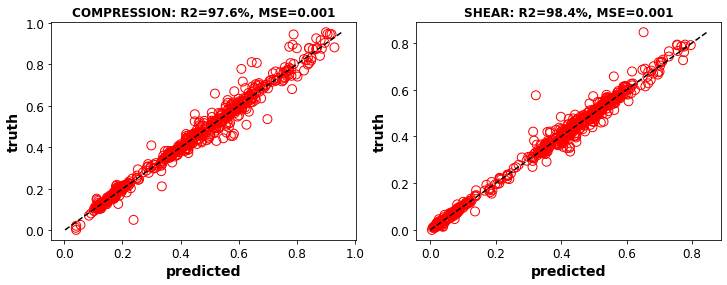

In [ ]:
# timer on
start_time = timer(None)
# define grid
my_grid = {'estimator__max_depth':[5,15,25,30],
         'estimator__n_estimators':[10,50,100,500,1000]}
# invoke RF
model= RandomForestRegressor()
# define wrapper for multi-output regressor
wrapper = MultiOutputRegressor(model)
# define grid search
gs= GridSearchCV(estimator=wrapper,
                  param_grid = my_grid,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
# perform GridSearch on the entire
# training set in order to find
# best params
grid_result = gs.fit(X_train, y_train)
# extract  best_parms
best_params = grid_result.best_params_
# define best RF model
best_model_rf = MultiOutputRegressor((RandomForestRegressor(max_depth=best_params['estimator__max_depth'],
                                        n_estimators=best_params['estimator__n_estimators'])))
# fit best RF model
best_model_rf.fit(X_train,y_train)
# make predictions on test set
predictions=best_model_rf.predict(X_test)
# evaluate prediction metrics
# for compression and shear
mse_compression=metrics.mean_squared_error(predictions[:,0],y_test['Compression Wave Travel Time'])
r2_compression=metrics.r2_score(predictions[:,0],y_test['Compression Wave Travel Time'])
mse_shear=metrics.mean_squared_error(predictions[:,1],y_test['Shear Wave Travel Time'])
r2_shear=metrics.r2_score(predictions[:,1],y_test['Shear Wave Travel Time'])
# plot results
preds=[predictions[:,0],predictions[:,1]]
true=[y_test['Compression Wave Travel Time'],y_test['Shear Wave Travel Time']]
target=["COMPRESSION","SHEAR"]
r2=[r2_compression,r2_shear]
mse=[mse_compression,mse_shear]
print(f"Best parameters:{grid_result.best_params_}")
plot_results(preds,true,target,r2,mse)
# save results to df
results_df.loc[2]=[["RF"],mse[0],mse[1]]
# timer off
timer(start_time)

The Random Forest Regressor (RF) performs better than SVR and DT on the TEST SET, as it can be seen in the dataframe below and in the previous plots. However, its computational cost is higher (roughly 2min and 30 sec against roughly 5 sec).

RFs are ensemble models combining boostrapping+aggregation. RF uses techniques to inject randomness into the algorithm, which helps create uncorrelated tree models, thus reducing bias and variance. Notice each tree features a max_depth=30, so they grow deep with the purpose of reducing bias. The subsequent combination of uncorrelated trees then help reduce variance. 

In [ ]:
results_df.head()

,model,MSE COMP,MSE SHEAR
0,[SVR],0.003860,0.002962
1,[DT],0.002547,0.001139
2,[RF],0.001083,0.000615


The RF model also allows better interpretability than SVRs, as it allows the user to gain access to the rank of feature importance, as shown below for Compression and Shear Wave. We learn that Gamma Ray and Total Porosity are the top-2 features for predicting Compression Wave, while Gamma Ray and Depth are the top-2 features for predicting Shear Wave. 

Please notice that even though Total Porosity and Effective Porosity are highly correlated, their feature importances are markedly different.

In [ ]:
# print feature importances for Compression Wave
print("COMPRESSION WAVE FEATURE IMPORTANCE")
for importance, name in sorted(zip(best_model.estimators_[0].feature_importances_, X_train.columns),reverse=True)[:6]:
    print (name, importance)
# print feature importances for Shear Wave
print("====================================")
print("SHEAR WAVE FEATURE IMPORTANCE")
for importance, name in sorted(zip(best_model.estimators_[1].feature_importances_, X_train.columns),reverse=True)[:6]:
    print (name, importance)

COMPRESSION WAVE FEATURE IMPORTANCE
Gamma Ray 0.659811150717301
Total Porosity 0.17198810969741454
Depth 0.1317867075683419
Effective Porosity 0.01422205435837845
Resistivity 0.013554882647180216
Bulk Density 0.00863709501138396
SHEAR WAVE FEATURE IMPORTANCE
Gamma Ray 0.8308890117596596
Depth 0.12495598304384507
Total Porosity 0.01769764968797864
Resistivity 0.012291644283123543
Bulk Density 0.008315227338931542
Effective Porosity 0.00585048388646168


**KNN**

Best parameters:{'estimator__leaf_size': 1, 'estimator__n_neighbors': 1, 'estimator__p': 1, 'estimator__weights': 'uniform'}

 Time taken: 0 hours 0 minutes and 5.2 seconds.


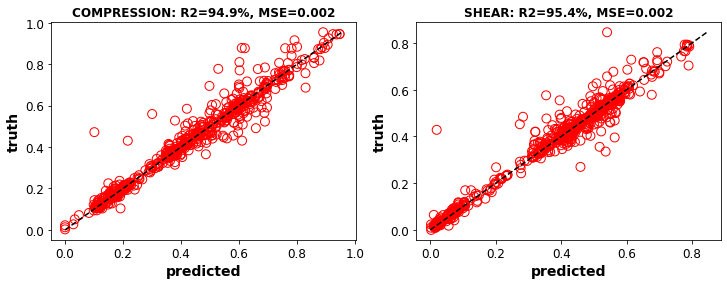

In [ ]:
# timer on
start_time = timer(None)
# define grid
my_grid = {'estimator__leaf_size':[1,10,20,30,40],
         'estimator__n_neighbors':[1,10,20,30,40],
         'estimator__p': [1,2],
         'estimator__weights': ['uniform','distance']}
# invoke KNN
model=neighbors.KNeighborsRegressor()
# define wrapper for multi-output regressor
wrapper = MultiOutputRegressor(model)
# define grid search
gs= GridSearchCV(estimator=wrapper,
                  param_grid = my_grid,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
# perform GridSearch on the entire
# training set in order to find
# best params
grid_result = gs.fit(X_train, y_train)
# extract  best_parms
best_params = grid_result.best_params_
# define best KNN model
best_model_knn = MultiOutputRegressor((neighbors.KNeighborsRegressor(leaf_size=best_params['estimator__leaf_size'],
                                        n_neighbors=best_params['estimator__n_neighbors'],
                                        p=best_params['estimator__p'],
                                        weights=best_params['estimator__weights'])))
# fit best KNN model
best_model_knn.fit(X_train,y_train)
# make predictions on test set
predictions=best_model_knn.predict(X_test)
# evaluate prediction metrics
# for compression and shear
mse_compression=metrics.mean_squared_error(predictions[:,0],y_test['Compression Wave Travel Time'])
r2_compression=metrics.r2_score(predictions[:,0],y_test['Compression Wave Travel Time'])
mse_shear=metrics.mean_squared_error(predictions[:,1],y_test['Shear Wave Travel Time'])
r2_shear=metrics.r2_score(predictions[:,1],y_test['Shear Wave Travel Time'])
# plot results
preds=[predictions[:,0],predictions[:,1]]
true=[y_test['Compression Wave Travel Time'],y_test['Shear Wave Travel Time']]
target=["COMPRESSION","SHEAR"]
r2=[r2_compression,r2_shear]
mse=[mse_compression,mse_shear]
print(f"Best parameters:{grid_result.best_params_}")
plot_results(preds,true,target,r2,mse)
# save results to df
results_df.loc[3]=[["KNN"],mse[0],mse[1]]
# timer off
timer(start_time)

The KNN model shows comparable results with DT. It performs better than SVR but it cannot outperform RF. Its computational cost is on a par with SVR and DT´s.

In [ ]:
results_df.head()

,model,MSE COMP,MSE SHEAR
0,[SVR],0.003860,0.002962
1,[DT],0.002547,0.001139
2,[RF],0.001083,0.000615
3,[KNN],0.002298,0.001773


**Gradient Boosting**

Best parameters:{'estimator__learning_rate': 0.15, 'estimator__max_depth': 4, 'estimator__min_samples_leaf': 3, 'estimator__n_estimators': 200}

 Time taken: 0 hours 1 minutes and 29.01 seconds.


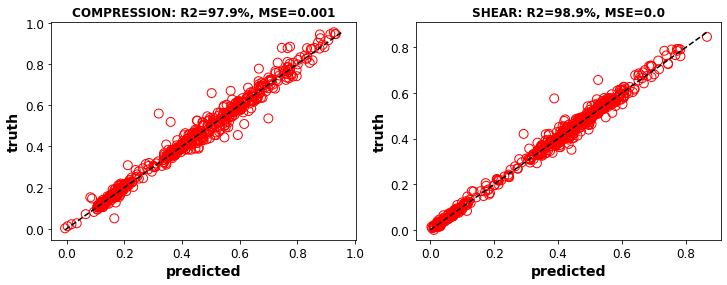

In [ ]:
# timer on
start_time = timer(None)
# define grid
my_grid = {'estimator__learning_rate': np.linspace(0.05, 0.15,5),
                      'estimator__max_depth' : range(3, 5),
                      'estimator__min_samples_leaf': range(3, 5),
                      'estimator__n_estimators' : [100,150,200]}
# invoke GB
model=GradientBoostingRegressor()
# define wrapper for multi-output regressor
wrapper = MultiOutputRegressor(model)
# define grid search
gs= GridSearchCV(estimator=wrapper,
                  param_grid = my_grid,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
# perform GridSearch on the entire
# training set in order to find
# best params
grid_result = gs.fit(X_train, y_train)
# extract  best_parms
best_params = grid_result.best_params_
# define best GB model
best_model_gb = MultiOutputRegressor((GradientBoostingRegressor(learning_rate=best_params['estimator__learning_rate'],
                                        max_depth=best_params['estimator__max_depth'],
                                        min_samples_leaf=best_params['estimator__min_samples_leaf'],
                                        n_estimators=best_params['estimator__n_estimators'])))
# fit best GB model
best_model_gb.fit(X_train,y_train)
# make predictions on test set
predictions=best_model_gb.predict(X_test)
# evaluate prediction metrics
# for compression and shear
mse_compression=metrics.mean_squared_error(predictions[:,0],y_test['Compression Wave Travel Time'])
r2_compression=metrics.r2_score(predictions[:,0],y_test['Compression Wave Travel Time'])
mse_shear=metrics.mean_squared_error(predictions[:,1],y_test['Shear Wave Travel Time'])
r2_shear=metrics.r2_score(predictions[:,1],y_test['Shear Wave Travel Time'])
# plot results
preds=[predictions[:,0],predictions[:,1]]
true=[y_test['Compression Wave Travel Time'],y_test['Shear Wave Travel Time']]
target=["COMPRESSION","SHEAR"]
r2=[r2_compression,r2_shear]
mse=[mse_compression,mse_shear]
print(f"Best parameters:{grid_result.best_params_}")
plot_results(preds,true,target,r2,mse)
# save results to df
results_df.loc[4]=[["GB"],mse[0],mse[1]]
# timer off
timer(start_time)

**The Gradient Boosting (GB) model has delivered the lowest MSE on the TEST SET,** as evidenced in the previous plots and in the table below.

Its computational cost is similar to RF´s. 

It is also an ensemble model. However, unlike RF, the trees are added sequentially, and fitted on the residues of the previous models. 

Each tree is short (max_depth=4), but as they´re sequentially added, the errors of the previous ones are progressively corrected.

In [ ]:
results_df.head()

,model,MSE COMP,MSE SHEAR
0,[SVR],0.003860,0.002962
1,[DT],0.002547,0.001139
2,[RF],0.001083,0.000615
3,[KNN],0.002298,0.001773
4,[GB],0.000949,0.000433


**Kernel Ridge**

Best parameters:{'estimator__alpha': 0.1, 'estimator__gamma': 10, 'estimator__kernel': 'rbf'}

 Time taken: 0 hours 0 minutes and 21.75 seconds.


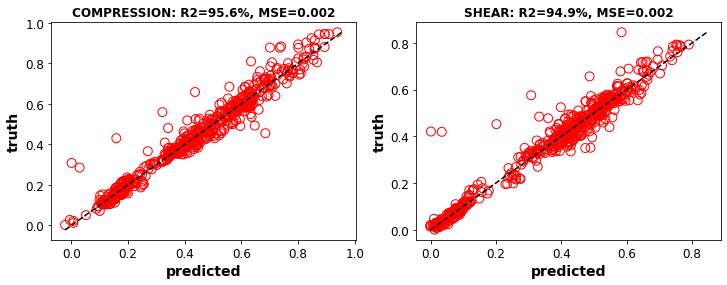

In [ ]:
# timer on
start_time = timer(None)
# define grid
my_grid = {'estimator__kernel': ["rbf","linear","sigmoid"],
            'estimator__gamma' : [10,1,0.1,0.01,1000],
            'estimator__alpha': [0.1,1,10,100,1000],
                      }
# invoke KR
model=KernelRidge()
# define wrapper for multi-output regressor
wrapper = MultiOutputRegressor(model)
# define grid search
gs= GridSearchCV(estimator=wrapper,
                  param_grid = my_grid,
                  cv=cv_inner,
                  scoring='neg_mean_squared_error',
                  verbose=0,
                  n_jobs=-1,
                  refit=True)
# perform GridSearch on the entire
# training set in order to find
# best params
grid_result = gs.fit(X_train, y_train)
# extract  best_parms
best_params = grid_result.best_params_
# define best KR model
best_model_kr = MultiOutputRegressor((KernelRidge(kernel=best_params['estimator__kernel'],
                                        gamma=best_params['estimator__gamma'],
                                        alpha=best_params['estimator__alpha'])))
# fit best KR model
best_model_kr.fit(X_train,y_train)
# make predictions on test set
predictions=best_model_kr.predict(X_test)
# evaluate prediction metrics
# for compression and shear
mse_compression=metrics.mean_squared_error(predictions[:,0],y_test['Compression Wave Travel Time'])
r2_compression=metrics.r2_score(predictions[:,0],y_test['Compression Wave Travel Time'])
mse_shear=metrics.mean_squared_error(predictions[:,1],y_test['Shear Wave Travel Time'])
r2_shear=metrics.r2_score(predictions[:,1],y_test['Shear Wave Travel Time'])
# plot results
preds=[predictions[:,0],predictions[:,1]]
true=[y_test['Compression Wave Travel Time'],y_test['Shear Wave Travel Time']]
target=["COMPRESSION","SHEAR"]
r2=[r2_compression,r2_shear]
mse=[mse_compression,mse_shear]
print(f"Best parameters:{grid_result.best_params_}")
plot_results(preds,true,target,r2,mse)
# save results to df
results_df.loc[5]=[["KR"],mse[0],mse[1]]
# timer off
timer(start_time)

Finally, our last model is a kernel-based one using the kernel-trick, in the same way as the SVR. However, the Kernel Ridge (KR) model is denser than SVRs, as the Kernels are computed across all samples, as opposed to only being computed using the support vectors. KR model can be regarded as a 2-layer network, where the 1st layers is trained in an unsupervised manner using all available training samples as templates. The 2nd layer contains weights trained in a suppervised manner.

For this particular problem, KR´s MSE on the TEST SET is lower than SVR's. 

Finally, a comparison of all models reveals that GB and RF are the ones with the lowest MSEs on the TEST SET. 

In [ ]:
results_df.head(6)

,model,MSE COMP,MSE SHEAR
0,[SVR],0.003860,0.002962
1,[DT],0.002547,0.001139
2,[RF],0.001083,0.000615
3,[KNN],0.002298,0.001773
4,[GB],0.000949,0.000433
5,[KR],0.001930,0.001905


**Model Comparison**

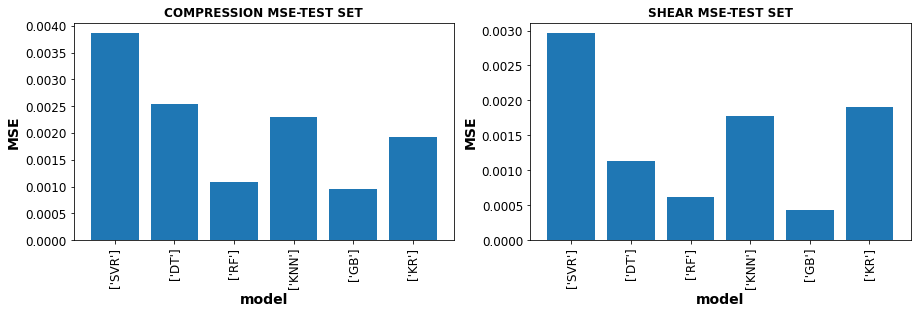

In [ ]:
results_df.set_index('model', inplace=True)
# let us now plot the dataframe
labels=["COMPRESSION MSE-TEST SET","SHEAR MSE-TEST SET"]
subplots=(121,122)
columns=["MSE COMP","MSE SHEAR"]
plt.figure(figsize=(15,4))
for label,subplot,column in zip(labels,subplots,columns):
  plt.subplot(subplot)
  ind = range(len(results_df.index))
  plt.bar(ind, results_df[column].values);
  plt.xticks(ind, results_df.index, rotation='vertical');
  plt.xlabel("model")
  plt.ylabel("MSE")
  plt.title(label)

Using the TEST SET, all models perform better than SVRs both both targets (Compression and Shear Wave). 

In [ ]:
# get a voting ensemble of models
def get_models(model_list,model_name):
  models = list()
  for mdl,mdl_name in zip(model_list,model_name):
	  models.append((mdl_name,mdl))
  return models
#_______________________________________________________________________________
def fit_ensemble(models, X_train, X_val, y_train, y_val):
	# fit all models on the training set and predict on hold out set
  meta_X = list()
  for name, model in models:
		# fit in training set
    model.fit(X_train, y_train)
		# predict on hold out set
    yhat = model.predict(X_val)
		# reshape predictions into a matrix with one column
    yhat = yhat.reshape(len(yhat), 2)
		# store predictions as input for blending
    meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
  meta_X = np.hstack(meta_X)
	# define blending model
  blender = LinearRegression()
	# fit on predictions from base models
  blender.fit(meta_X, y_val)
  return blender
#_______________________________________________________________________________

def predict_ensemble(models, blender, X_test):
  # make predictions with base models
  meta_X = list()
  for name, model in models:
		# predict with base model
    yhat = model.predict(X_test)
		# reshape predictions into a matrix with one column
    yhat = yhat.reshape(len(yhat), 2)
		# store prediction
    meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
  meta_X = np.hstack(meta_X)
	# predict
  return blender.predict(meta_X)
#_______________________________________________________________________________


Best parameters:{'estimator__alpha': 0.1, 'estimator__gamma': 10, 'estimator__kernel': 'rbf'}


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


ValueError: ignored

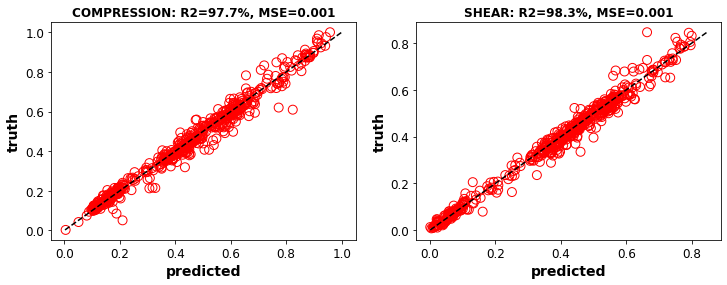

In [ ]:
# timer on
start_time = timer(None)
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train,test_size=0.1,shuffle=True,random_state=42)
model_list=[best_model_gb,best_model_rf]#,best_model_kr,best_model_knn,best_model_dt
model_name=["gb","rf"]
model = get_models(model_list,model_name)
blender = fit_ensemble(model, X_tr, X_val, y_tr, y_val)
predictions = predict_ensemble(model, blender, X_test)
# evaluate prediction metrics
# for compression and shear
mse_compression=metrics.mean_squared_error(predictions[:,0],y_test['Compression Wave Travel Time'])
r2_compression=metrics.r2_score(predictions[:,0],y_test['Compression Wave Travel Time'])
mse_shear=metrics.mean_squared_error(predictions[:,1],y_test['Shear Wave Travel Time'])
r2_shear=metrics.r2_score(predictions[:,1],y_test['Shear Wave Travel Time'])
# plot results
preds=[predictions[:,0],predictions[:,1]]
true=[y_test['Compression Wave Travel Time'],y_test['Shear Wave Travel Time']]
target=["COMPRESSION","SHEAR"]
r2=[r2_compression,r2_shear]
mse=[mse_compression,mse_shear]
print(f"Best parameters:{grid_result.best_params_}")
plot_results(preds,true,target,r2,mse)
# save results to df
results_df.loc[6]=[["BLENDER"],mse[0],mse[1]]
# timer off
timer(start_time)

In [ ]:
mse[1]

0.0006785669174624402

In [ ]:
results_df.head(8)

,MSE COMP,MSE SHEAR
model,,
[SVR],0.003860,0.002962
[DT],0.002405,0.001112
[RF],0.001059,0.000595
[KNN],0.002298,0.001773
[GB],0.000947,0.000436
[KR],0.001930,0.001905
[BLENDER],0.001276,0.000922


In [ ]:
!pip install mlens

     |████████████████████████████████| 227 kB 34.5 MB/s 


In [ ]:
# get a voting ensemble of models
def get_models(model_list):
  models = list()
  for mdl in model_list:
	  models.append(mdl)
  return models
#_______________________________________________________________________________
def rmse(yreal, yhat):
	return sqrt(mean_squared_error(yreal, yhat))
#_______________________________________________________________________________
def get_super_learner(X,models):
  #folds=3
  ensemble = SuperLearner(scorer=rmse, folds=10, shuffle=True, sample_size=len(X))
  ensemble.add(models)
  ensemble.add_meta(LinearRegression())
  return ensemble


In [ ]:
from mlens.ensemble import SuperLearner
# timer on
start_time = timer(None)
model_list=[best_model_gb,best_model_svr,best_model_knn]#,best_model_kr,best_model_knn,best_model_dt
model = get_models(model_list)
ensemble = get_super_learner(X_train,model)
ensemble.fit(np.array(X_train),np.array(y_train))
predictions = ensemble.predict (X_test)
# evaluate prediction metrics
# for compression and shear
mse_compression=metrics.mean_squared_error(predictions[:,0],y_test['Compression Wave Travel Time'])
r2_compression=metrics.r2_score(predictions[:,0],y_test['Compression Wave Travel Time'])
#mse_shear=metrics.mean_squared_error(predictions[:,1],y_test['Shear Wave Travel Time'])
#r2_shear=metrics.r2_score(predictions[:,1],y_test['Shear Wave Travel Time'])
# plot results
preds=[predictions[:,0],predictions[:,1]]
true=[y_test['Compression Wave Travel Time'],y_test['Shear Wave Travel Time']]
target=["COMPRESSION","SHEAR"]
r2=[r2_compression,r2_shear]
mse=[mse_compression,mse_shear]
print(f"Best parameters:{grid_result.best_params_}")
plot_results(preds,true,target,r2,mse)
# save results to df
#results_df.loc[6]=[["BLENDER"],mse[0],mse[1]]
# timer off
timer(start_time)


/usr/local/lib/python3.7/dist-packages/mlens/parallel/_base_functions.py:226: MetricWarning: [multioutputregressor-1.0.1] Could not score multioutputregressor-1. Details:
NameError("name 'sqrt' is not defined")
  (name, inst_name, exc), MetricWarning)
/usr/local/lib/python3.7/dist-packages/mlens/parallel/_base_functions.py:226: MetricWarning: [multioutputregressor-1.0.2] Could not score multioutputregressor-1. Details:
NameError("name 'sqrt' is not defined")
  (name, inst_name, exc), MetricWarning)
/usr/local/lib/python3.7/dist-packages/mlens/parallel/_base_functions.py:226: MetricWarning: [multioutputregressor-1.0.3] Could not score multioutputregressor-1. Details:
NameError("name 'sqrt' is not defined")
  (name, inst_name, exc), MetricWarning)
/usr/local/lib/python3.7/dist-packages/mlens/parallel/_base_functions.py:226: MetricWarning: [multioutputregressor-1.0.4] Could not score multioutputregressor-1. Details:
NameError("name 'sqrt' is not defined")
  (name, inst_name, exc), MetricW

JoblibValueError: ignored

In [ ]:
results_df.head()

,MSE COMP,MSE SHEAR
model,,
[SVR],0.003860,0.002962
[DT],0.002405,0.001112
[RF],0.001059,0.000595
[KNN],0.002298,0.001773
[GB],0.000947,0.000436


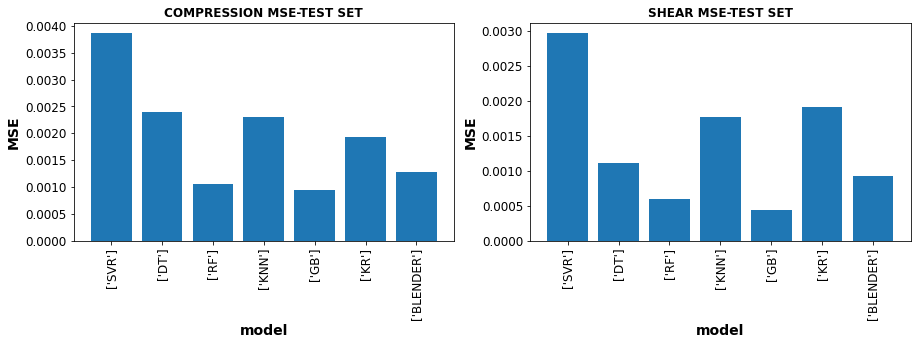

In [ ]:
results_df.set_index('model', inplace=True)
# let us now plot the dataframe
labels=["COMPRESSION MSE-TEST SET","SHEAR MSE-TEST SET"]
subplots=(121,122)
columns=["MSE COMP","MSE SHEAR"]
plt.figure(figsize=(15,4))
for label,subplot,column in zip(labels,subplots,columns):
  plt.subplot(subplot)
  ind = range(len(results_df.index))
  plt.bar(ind, results_df[column].values);
  plt.xticks(ind, results_df.index, rotation='vertical');
  plt.xlabel("model")
  plt.ylabel("MSE")
  plt.title(label)